# Mini - Project 1 

**Author**: Rohit Jorige , R Balaji , Ishaq Hamza

**Objectives**

- Implement a binomial tree model to price a European Call or Put option with different strike prices listed on NSE.

- Plot the results for different numbers of steps in the binomial tree and check for convergence. 

- Compute Error with respect to the reference price. 

- Figure out a Hedging Strategy for the option and analyze the option in the context of greeks. 


## Data Processing
Here is how the NSE call option data looks like: 
 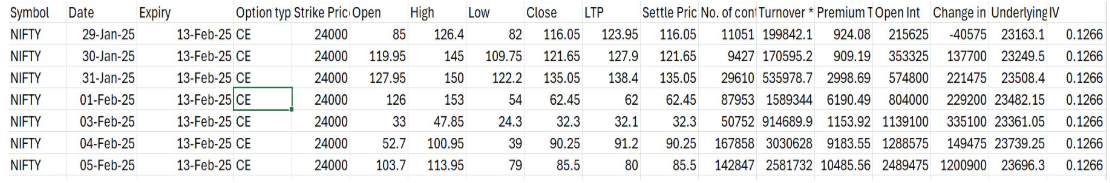

Put option data looks similar to the call option data.
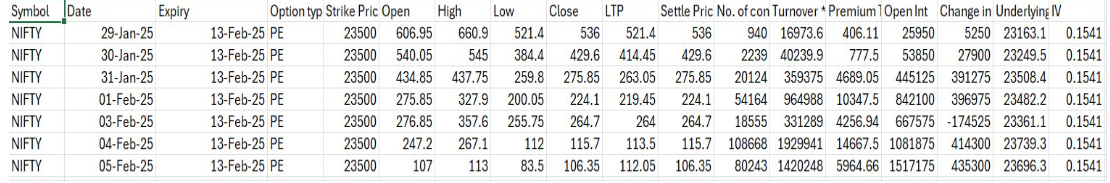

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import comb
from datetime import datetime

calls = pd.read_csv('Calls.csv')
puts = pd.read_csv('Puts.csv')
calls.columns = calls.columns.str.strip()
puts.columns = puts.columns.str.strip()

print("call option\n",calls.columns)
print("put optin\n",puts.columns)

/home/rohit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


call option
 Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Open',
       'High', 'Low', 'Close', 'LTP', 'Settle Price', 'No. of contracts',
       'Turnover * in  ₹ Lakhs', 'Premium Turnover ** in   ₹ Lakhs',
       'Open Int', 'Change in OI', 'Underlying Value', 'IV'],
      dtype='object')
put optin
 Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Open',
       'High', 'Low', 'Close', 'LTP', 'Settle Price', 'No. of contracts',
       'Turnover * in  ₹ Lakhs', 'Premium Turnover ** in   ₹ Lakhs',
       'Open Int', 'Change in OI', 'Underlying Value', 'IV'],
      dtype='object')


## Binomial Tree Model 
We will implement a binomial tree model to price a European Call or Put option with different strike prices listed on NSE. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime

def print_tree(tree, title, N):
    """Helper function to print full tree structure"""
    print(f"\n=== {title} ===")
    for i in range(N + 1):
        print(f"Step {i}:", end=" ")
        for j in range(i + 1):
            print(f"{tree[j, i]:10.2f}", end=" ")
        print()  # New line after each step

def visualize_binomial_tree(stock_tree, option_tree, N):
    """
    Visualize the binomial tree using networkx with larger text inside the nodes.
    """
    import networkx as nx
    import matplotlib.pyplot as plt
    
    G = nx.DiGraph()
    
    # Add nodes and edges
    for i in range(N + 1):
        for j in range(i + 1):
            G.add_node((i, j), stock_price=stock_tree[j, i], option_price=option_tree[j, i])
            if i < N:
                G.add_edge((i, j), (i + 1, j))
                G.add_edge((i, j), (i + 1, j + 1))
    
    pos = {}
    for i in range(N + 1):
        for j in range(i + 1):
            pos[(i, j)] = (i, -j)
    
    # Increase text size in the node labels by setting font_size
    labels = {(i, j): f"{stock_tree[j, i]:.2f}\n{option_tree[j, i]:.2f}" 
              for i in range(N + 1) for j in range(i + 1)}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, 
            node_color='lightblue', font_size=16, font_color='black', font_weight='bold')
    plt.title("Binomial Tree Visualization\n(Stock Price / Option Price)", fontsize=18)
    plt.show()

def binomial_tree(S0, K, T, r, sigma, N, option_type='call', print_trees=False, visualize=False):
    """
    Binomial tree with option to print full trees and visualize
    Returns both price and full trees for stock prices and option values
    """
    if T <= 0:
        return max(S0 - K, 0) if option_type == 'call' else max(K - S0, 0)
    
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # Initialize stock price and option value trees
    stock_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))
    
    # Build stock price tree
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)
    
    # Calculate terminal option values
    for j in range(N + 1):
        if option_type == 'call':
            option_tree[j, N] = max(stock_tree[j, N] - K, 0)
        else:
            option_tree[j, N] = max(K - stock_tree[j, N], 0)
    
    # Backward induction for option values
    for i in range(N-1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = discount * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])
    
    if print_trees:
        print("\n=== Binomial Tree Parameters ===")
        print(f"Up factor (u): {u:.4f}")
        print(f"Down factor (d): {d:.4f}")
        print(f"Risk-neutral probability (p): {p:.4f}")
        print(f"Time step (dt): {dt:.4f}")
        
        print_tree(stock_tree, "Stock Price Tree", N)
        print_tree(option_tree, "Option Value Tree", N)
        
        print("\n=== Option Pricing Results ===")
        print(f"Option Type: {option_type.capitalize()}")
        print(f"Initial Stock Price: {S0:.2f}")
        print(f"Strike Price: {K:.2f}")
        print(f"Time to Maturity: {T:.2f}")
        print(f"Risk-free Rate: {r:.4f}")
        print(f"Volatility: {sigma:.4f}")
        print(f"Number of Steps: {N}")
        print(f"Option Price: {option_tree[0, 0]:.4f}")
    
    if visualize:
        visualize_binomial_tree(stock_tree, option_tree, N)
    
    return option_tree[0, 0], stock_tree, option_tree


### Binomial Tree for the Call Option


=== Binomial Tree Parameters ===
Up factor (u): 1.0109
Down factor (d): 0.9892
Risk-neutral probability (p): 0.5192
Time step (dt): 0.0073

=== Stock Price Tree ===
Step 0:   23696.30 
Step 1:   23954.11   23441.26 
Step 2:   24214.73   23696.30   23188.97 
Step 3:   24478.18   23954.11   23441.26   22939.39 

=== Option Value Tree ===
Step 0:      66.83 
Step 1:     128.79       0.00 
Step 2:     248.16       0.00       0.00 
Step 3:     478.18       0.00       0.00       0.00 

=== Option Pricing Results ===
Option Type: Call
Initial Stock Price: 23696.30
Strike Price: 24000.00
Time to Maturity: 0.02
Risk-free Rate: 0.0649
Volatility: 0.1266
Number of Steps: 3
Option Price: 66.8346


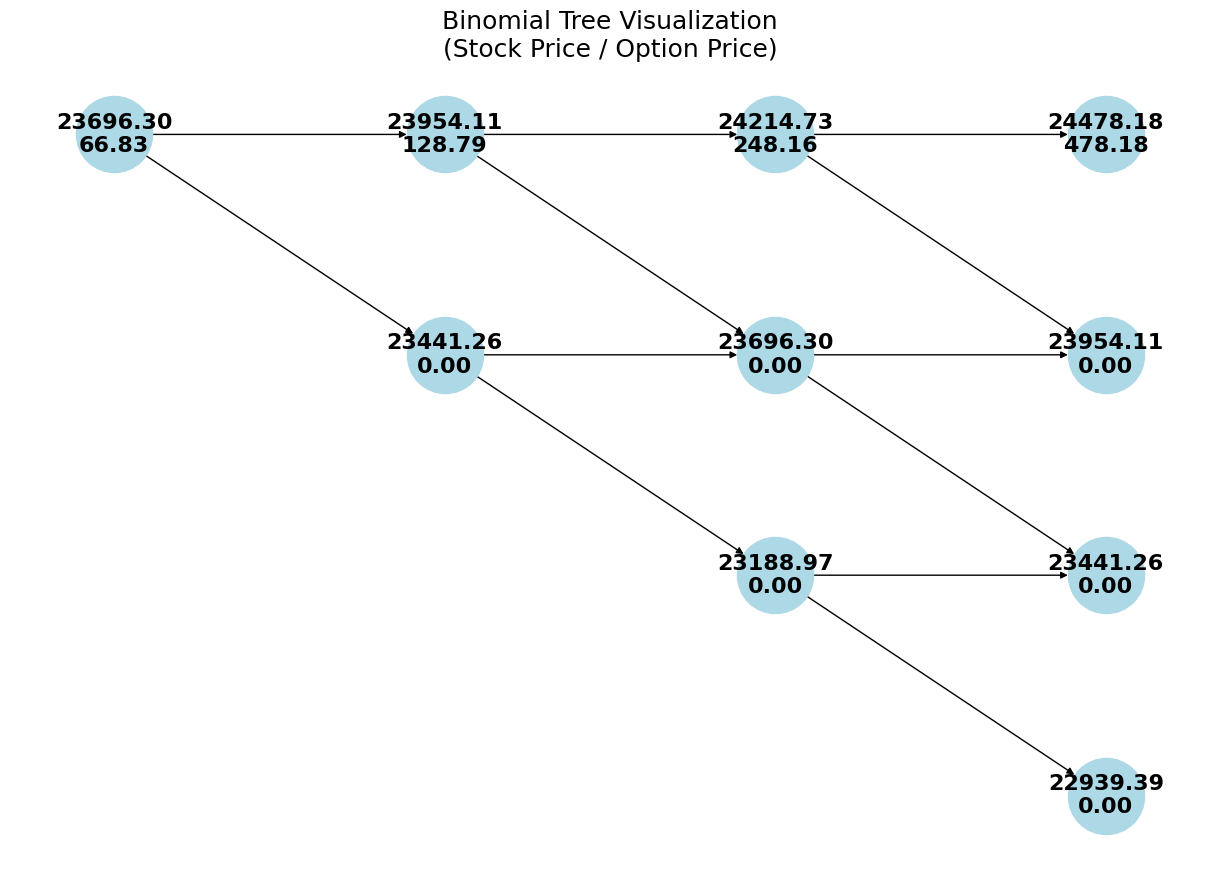

In [3]:

option = calls.loc[6]
S0 = option["Underlying Value"]
K = option["Strike Price"]
T = (datetime.strptime(option["Expiry"], "%d-%b-%y") - datetime.strptime(option["Date"], "%d-%b-%y")).days/365
sigma = option["IV"]
rf = 0.0649  # risk-free rate (from 10 Year bond value)
N = 3

call_price, stock_tree, call_tree = binomial_tree(S0, K, T, rf, sigma, N, 
                                                 option_type='call', 
                                                 print_trees=True,
                                                 visualize=True)

### Binomial Tree for the Put Option


=== Binomial Tree Parameters ===
Up factor (u): 1.0133
Down factor (d): 0.9869
Risk-neutral probability (p): 0.5147
Time step (dt): 0.0073

=== Stock Price Tree ===
Step 0:   23696.30 
Step 1:   24010.48   23386.23 
Step 2:   24328.83   23696.30   23080.21 
Step 3:   24651.41   24010.48   23386.23   22778.20 

=== Option Value Tree ===
Step 0:     123.69 
Step 1:      26.77     226.61 
Step 2:       0.00      55.19     408.65 
Step 3:       0.00       0.00     113.77     721.80 

=== Option Pricing Results ===
Option Type: Put
Initial Stock Price: 23696.30
Strike Price: 23500.00
Time to Maturity: 0.02
Risk-free Rate: 0.0649
Volatility: 0.1541
Number of Steps: 3
Option Price: 123.6916


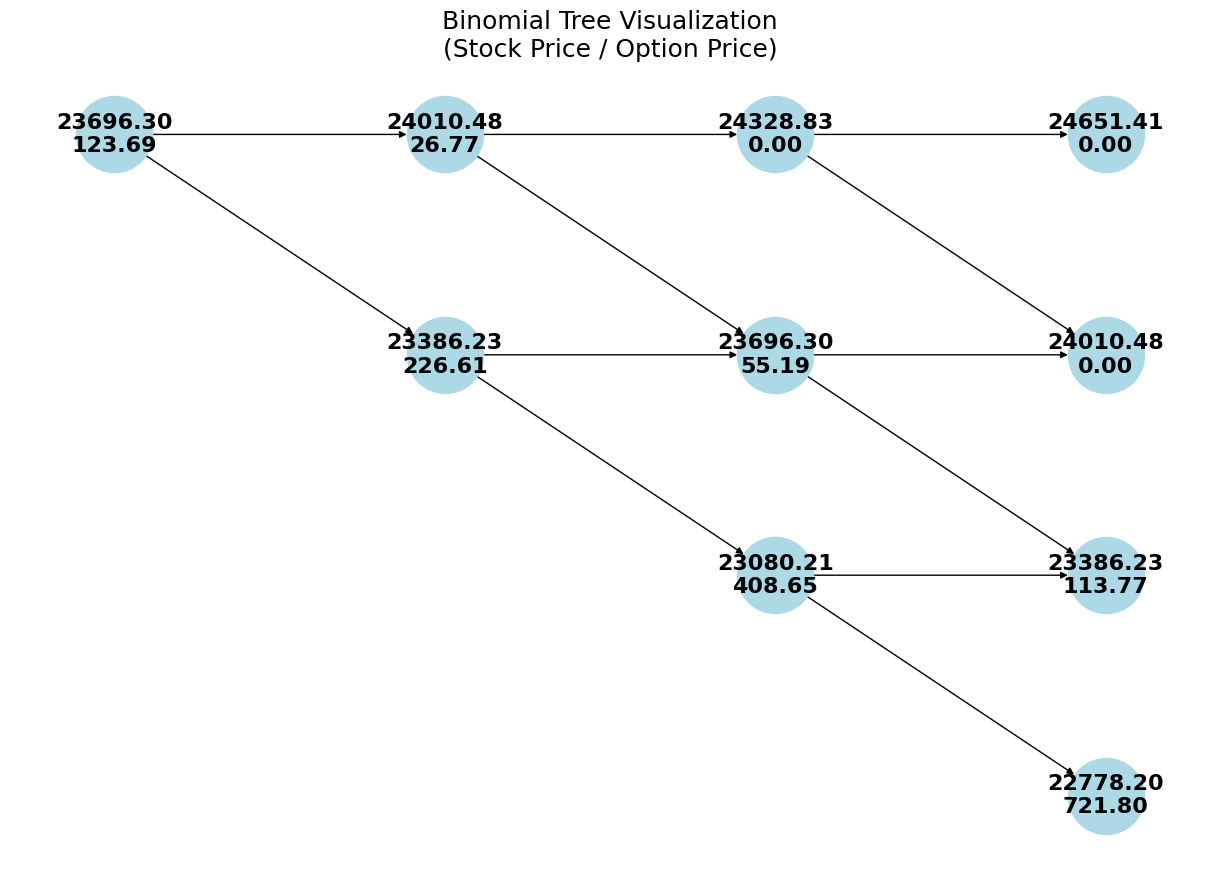

In [4]:

option = puts.loc[6]
S0 = option["Underlying Value"]
K = option["Strike Price"]
T = (datetime.strptime(option["Expiry"], "%d-%b-%y") - datetime.strptime(option["Date"], "%d-%b-%y")).days/365
sigma = option["IV"]
rf = 0.0649  # risk-free rate (from 10 Year bond value)
N = 3

call_price, stock_tree, call_tree = binomial_tree(S0, K, T, rf, sigma, N, 
                                                 option_type='put', 
                                                 print_trees=True,
                                                 visualize=True)

## Black Scholes Model
We implement the Black Scholes Model to price the option and compare the results with the binomial tree model. 

- d1 represents the standardized distance from the threshold where the option is "in the money" under risk-neutral probability

- d2 represents an adjustment to d1 that accounts for the time value of the strike price

**d1 and d2 Calculations**

The d1 parameter is calculated as:
$$
d1 = \frac{\ln(S_0/K) + (r + \frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}
$$

The d2 parameter is then:
$$
d2 = d1 - \sigma\sqrt{T}
$$

**Option Pricing Formulas**

Call Option price:
$$
C = S_0 \times N(d1) - K \times e^{-rT} \times N(d2)
$$

Put Option price:
$$
P = K \times e^{-rT} \times N(-d2) - S_0 \times N(-d1)
$$

where:
- $S_0$ is the current stock price
- $K$ is the strike price
- $r$ is the risk-free rate
- $T$ is the time to maturity
- $\sigma$ is the volatility
- $N(.)$ is the cumulative normal distribution function

In [5]:
# Black-Scholes Model
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    if T <= 0:
        return max(S0 - K, 0) if option_type == 'call' else max(K - S0, 0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

### Plot Convergence of Binomial Model with Respect to the Black Scholes Model

In [6]:
def plot_convergence(S0, K, T, r, sigma, option_type='call', actual_price = None, max_steps=100):
    """
    Plot convergence of binomial model prices to Black-Scholes price
    """
    N_steps = np.arange(1, max_steps+1)
    bs_price = black_scholes(S0, K, T, r, sigma, option_type)
    # Extract only the price from binomial_tree results
    binomial_prices = [binomial_tree(S0, K, T, r, sigma, N, option_type)[0] for N in N_steps]
    errors = np.abs(np.array(binomial_prices) - bs_price)
    if actual_price is not None:
        actual_errors = np.abs(np.array(binomial_prices) - actual_price)
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(N_steps, binomial_prices, 'b-', label='Binomial Price')
    plt.axhline(bs_price, color='r', linestyle='--', label='Black-Scholes')
    if actual_price is not None:
        plt.axhline(actual_price, color='g', linestyle='--', label='Actual Price')
    plt.xlabel('Number of Steps')
    plt.ylabel('Option Price')
    plt.title('Convergence of Binomial Model')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(N_steps, errors, 'g-')
    plt.xlabel('Number of Steps')
    plt.ylabel('Absolute Error')
    plt.title('Error with Black-Scholes vs Number of Steps')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    if actual_price is not None:
        plt.subplot(1, 2, 2)
        plt.plot(N_steps, actual_errors, 'g-')
        plt.xlabel('Number of Steps')
        plt.ylabel('Absolute Error')
        plt.title('Error with Actual Price vs Number of Steps')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    print("\n=== Convergence Analysis ===")
    print(f"Black-Scholes Price: {bs_price:.4f}")
    print(f"Final Binomial Price ({max_steps} steps): {binomial_prices[-1]:.4f}")
    print(f"Final Absolute Error wrt Black Scholes: {errors[-1]:.4f}")
    # if actual_price is not None:
        # print(f"Actual Price: {actual_price:.4f}")
        # print(f"Final Absolute Error wrt Actual Price: {actual_errors[-1]:.4f}")
    return binomial_prices, errors


#### Call Option

In [7]:
%%capture
option = calls.loc[6]
S0 = option["Underlying Value"]
K = option["Strike Price"]
T = (datetime.strptime(option["Expiry"], "%d-%b-%y") - datetime.strptime(option["Date"], "%d-%b-%y")).days/365
sigma = option["IV"]
rf = 0.0649  # risk-free rate (from 10 Year bond value)
N = 3

call_price, stock_tree, call_tree = binomial_tree(S0, K, T, rf, sigma, N, 
                                                 option_type='call', 
                                                 print_trees=True,
                                                 visualize=True)

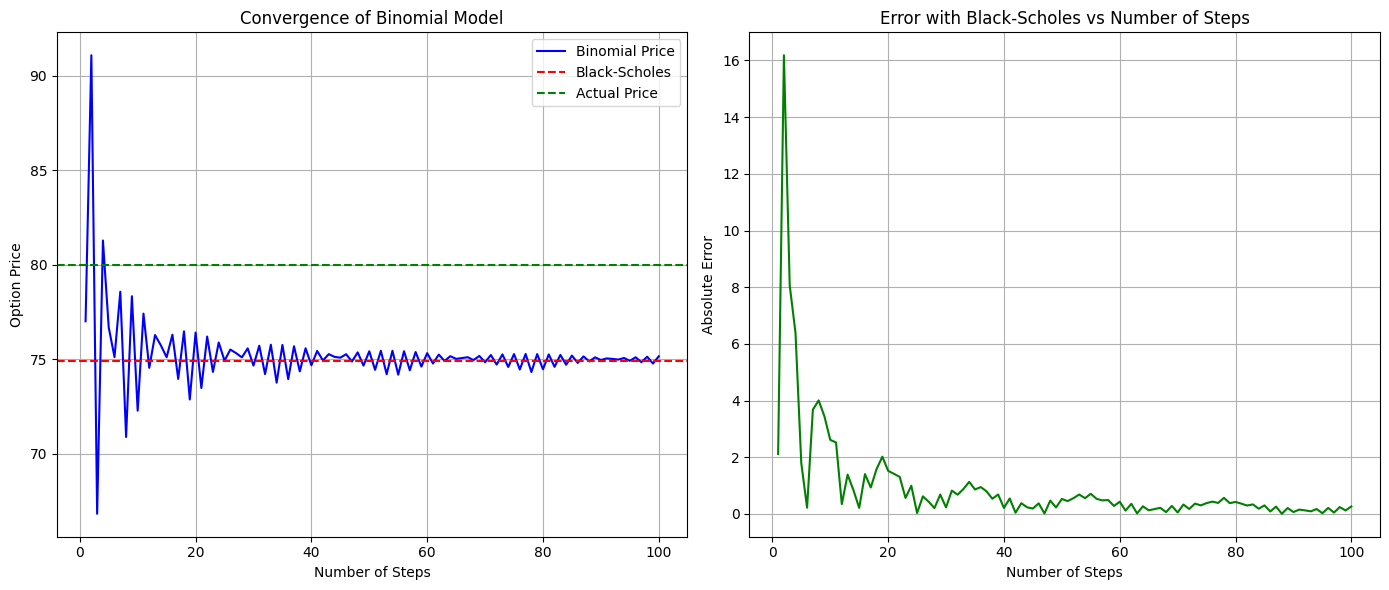

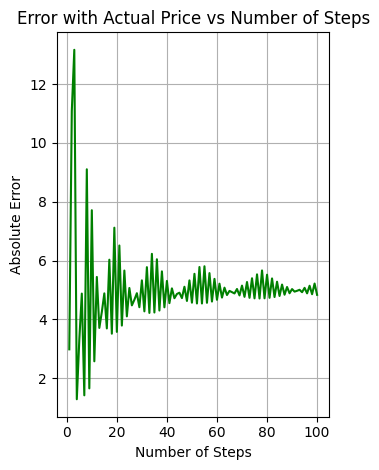


=== Convergence Analysis ===
Black-Scholes Price: 74.9004
Final Binomial Price (100 steps): 75.1631
Final Absolute Error wrt Black Scholes: 0.2627


In [8]:
bimoial_prices, errors =plot_convergence(S0, K, T, rf, sigma, option_type='call', max_steps=100, actual_price=option["LTP"])

#### Put Option

In [9]:
%%capture
option = puts.loc[6]
S0 = option["Underlying Value"]
K = option["Strike Price"]
T = (datetime.strptime(option["Expiry"], "%d-%b-%y") - datetime.strptime(option["Date"], "%d-%b-%y")).days/365
sigma = option["IV"]
rf = 0.0649  # risk-free rate (from 10 Year bond value)
N = 3

call_price, stock_tree, call_tree = binomial_tree(S0, K, T, rf, sigma, N, 
                                                 option_type='put', 
                                                 print_trees=True,
                                                 visualize=True)


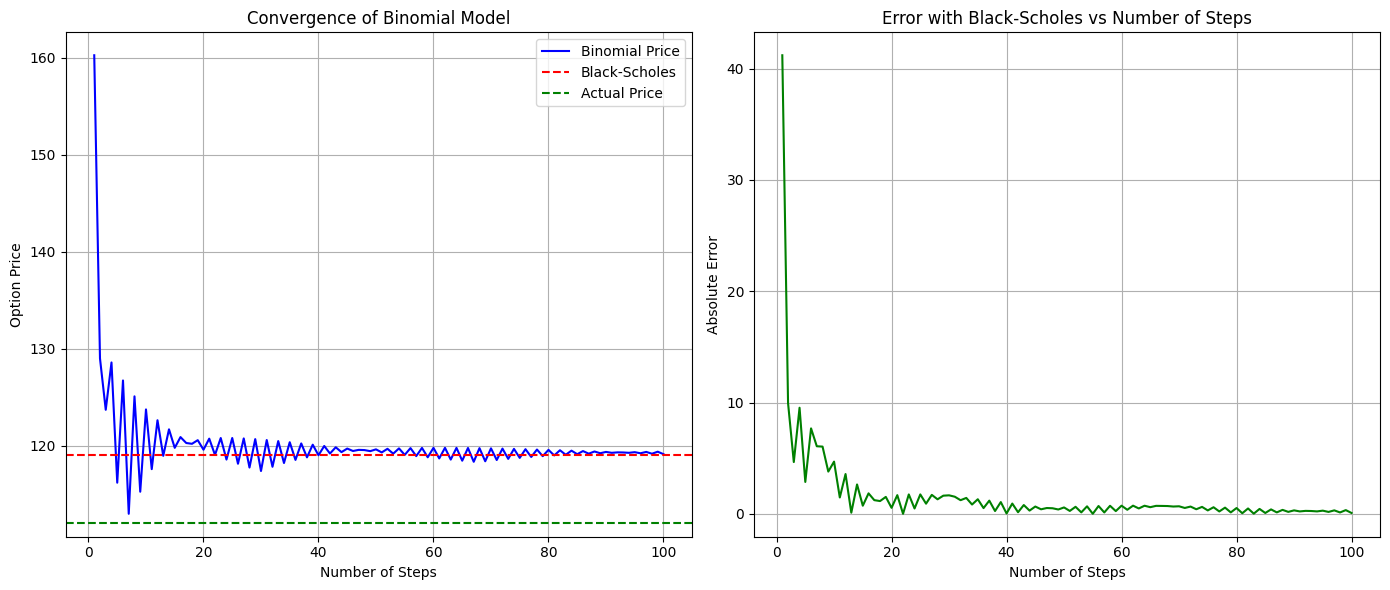

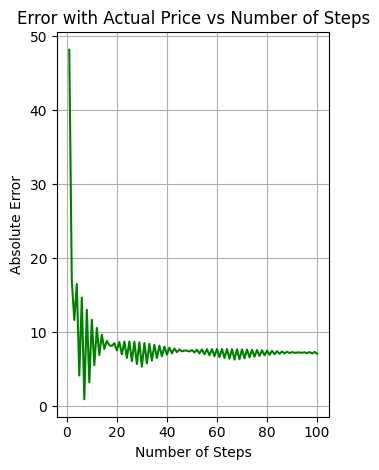


=== Convergence Analysis ===
Black-Scholes Price: 119.0394
Final Binomial Price (100 steps): 119.1145
Final Absolute Error wrt Black Scholes: 0.0751


In [10]:
bimoial_prices, errors =plot_convergence(S0, K, T, rf, sigma, option_type='put', max_steps=100, actual_price=option["LTP"])

## Hedging Strategy and Greeks

**1. Greeks Calculation via Finite Differences**

**Delta (Δ)**
First-order sensitivity to price, calculated using central difference with ε = 0.01:
$$
Δ = [V(S₀ + ε, K, T, r, σ) - V(S₀ - ε, K, T, r, σ)] / (2ε)
$$

**Gamma (Γ)**
Second-order sensitivity to price, calculated using central difference with ε = 0.01:
$$
Γ = [V(S₀ + ε, K, T, r, σ) - 2V(S₀, K, T, r, σ) + V(S₀ - ε, K, T, r, σ)] / ε²
$$

**Theta (Θ)**
Time decay sensitivity, calculated using forward difference with ε = 1/252 (one trading day):
$$
Θ = [V(S₀, K, T - ε, r, σ) - V(S₀, K, T, r, σ)] / (-ε)
$$

**Vega (ν)**
Volatility sensitivity, calculated using central difference with ε = 0.001:
$$
ν = [V(S₀, K, T, r, σ + ε) - V(S₀, K, T, r, σ - ε)] / (2ε)
$$

**2. Hedging Portfolio Dynamics**

At each time step i:

1. Interest accrual on cash position:
$$
cash_i = cash_{i-1} × e^{r×Δt}
$$

2. Portfolio value calculation:
$$
portfolio\_value_i = Δ_{i-1} × S_i + cash_i
$$

3. Portfolio rebalancing:
$$
cash_i = portfolio\_value_i - Δ_i × S_i
$$
$$
portfolio\_value_i = Δ_i × S_i + cash_i
$$

**3. Performance Metrics**

1. Average Hedging Error:
$$
avg\_error = mean(portfolio\_values - market\_prices)
$$

2. Maximum Absolute Hedging Error:
$$
max\_error = max|portfolio\_values - market\_prices|
$$

In [11]:
# Greeks Calculation
def delta(S0, K, T, r, sigma, N, option_type, epsilon=0.01):
    """Calculate delta using central difference"""
    C_up = binomial_tree(S0 + epsilon, K, T, r, sigma, N, option_type)[0]  # Get only price
    C_down = binomial_tree(S0 - epsilon, K, T, r, sigma, N, option_type)[0]  # Get only price
    return (C_up - C_down) / (2 * epsilon)

def delta_tree(option_tree, stock_tree):
    """compute the delta at each node and return as tree"""
    N = option_tree.shape[1] - 1
    delta_tree = np.zeros((N + 1, N + 1))
    for i in range(N):
        for j in range(i + 1):
            delta_tree[j, i] = (option_tree[j, i+1] - option_tree[j+1, i+1]) / (stock_tree[j, i] - stock_tree[j+1, i])
    return delta_tree

def gamma(S0, K, T, r, sigma, N, option_type, epsilon=0.01):
    """Calculate gamma using central difference"""
    C_up = binomial_tree(S0 + epsilon, K, T, r, sigma, N, option_type)[0]  # Get only price
    C_mid = binomial_tree(S0, K, T, r, sigma, N, option_type)[0]  # Get only price
    C_down = binomial_tree(S0 - epsilon, K, T, r, sigma, N, option_type)[0]  # Get only price
    return (C_up - 2 * C_mid + C_down) / (epsilon ** 2)

def gamma_tree(delta_tree, stock_tree):
    """compute the gamma at each node and return as tree"""
    N = delta_tree.shape[1] - 1
    gamma_tree = np.zeros((N + 1, N + 1))
    for i in range(N - 1):
        for j in range(i + 1):
            gamma_tree[j, i] = (delta_tree[j, i] - delta_tree[j+1, i]) / (stock_tree[j, i] - stock_tree[j+1, i])
    return gamma_tree

def theta(S0, K, T, r, sigma, N, option_type, epsilon=1/252):
    """Calculate theta using forward difference"""
    new_T = max(T - epsilon, 1e-6)  # Avoid T=0
    C_new = binomial_tree(S0, K, new_T, r, sigma, N, option_type)[0]  # Get only price
    C_old = binomial_tree(S0, K, T, r, sigma, N, option_type)[0]  # Get only price
    return (C_new - C_old) / (-epsilon)

def theta_tree(option_tree, dt):
    """compute the theta at each node and return as tree"""
    N = option_tree.shape[1] - 1
    theta_tree = np.zeros((N + 1, N + 1))
    for i in range(N):
        for j in range(i + 1):
            theta_tree[j, i] = (option_tree[j, i+1] - option_tree[j, i]) / dt
    return theta_tree

def vega(S0, K, T, r, sigma, N, option_type, epsilon=0.001):
    """Calculate vega using central difference"""
    C_up = binomial_tree(S0, K, T, r, sigma + epsilon, N, option_type)[0]  # Get only price
    C_down = binomial_tree(S0, K, T, r, sigma - epsilon, N, option_type)[0]  # Get only price
    return (C_up - C_down) / (2 * epsilon)

# # Vega: For vega we still use a finite difference (since replicating portfolio doesn't give vega directly)
# def vega(S0, K, T, r, sigma, N, option_type, rel_epsilon=0.005):
#     """
#     Calculate vega using central difference (finite difference method).
#     rel_epsilon is a relative perturbation on sigma.
#     """
#     eps = rel_epsilon * sigma
#     price_up = binomial_tree(S0, K, T, r, sigma + eps, N, option_type)[0]
#     price_down = binomial_tree(S0, K, T, r, sigma - eps, N, option_type)[0]
#     return (price_up - price_down) / (2 * eps)

# Compute the greek trees
# print("\n=== Greek Trees ===")
# delta_tree_call = delta_tree(call_tree, stock_tree)
# gamma_tree_call = gamma_tree(delta_tree_call, stock_tree)
# theta_tree_call = theta_tree(call_tree, T / N)

# print_tree(delta_tree_call, "Delta Tree (Call)", N)
# print_tree(gamma_tree_call, "Gamma Tree (Call)", N)
# print_tree(theta_tree_call, "Theta Tree (Call)", N)


# Hedging Analysis using the replicating portfolio Greeks and finite difference for vega
def hedging_analysis(option_data, K, r, sigma, N_steps=1000, option_type='call'):
    """Perform hedging analysis with replicating-portfolio Greeks using a time axis based on the input T."""
    # Prepare the option data (ignore actual dates)
    option_data = option_data.copy()
    # We assume option_data contains at least:
    #   'Underlying Value' and 'Close' (market option price)
    # Also, we assume option_data contains a column 'T' (time to maturity in years)
    valid_data = option_data[option_data['T'] > 0].copy()
    valid_data = valid_data.sort_values('T')
    
    # Instead of using dates, create a time axis (in years) equally spaced over the period T provided as input.
    n_points = len(valid_data)
    # Create time points from 0 to the maximum time in the data
    time_axis = np.linspace(0, valid_data['T'].max(), n_points)
    
    portfolio_values = []
    market_prices = []
    deltas = []
    gammas = []
    thetas = []
    vegas_list = []
    time_points = []  # time in years from 0 to T_max
    
    cash = 0
    prev_delta = 0
    initial = True
    prev_time = 0
    
    # Iterate over the valid data, using our generated time axis instead of dates.
    for i, (_, row) in enumerate(valid_data.iterrows()):
        S = row['Underlying Value']
        T_remaining = row['T']  # time to maturity from the observation
        market_price = row['Close']
        current_time = time_axis[i]
        
        try:
            # Compute replicating-portfolio Greeks from the binomial tree:
            current_delta = delta(S, K, T_remaining, r, sigma, N_steps, option_type)
            current_gamma = gamma(S, K, T_remaining, r, sigma, N_steps, option_type)
            current_theta = theta(S, K, T_remaining, r, sigma, N_steps, option_type)
            current_vega = vega(S, K, T_remaining, r, sigma, N_steps, option_type)
            
            if initial:
                # Initial hedge setup: set up replicating portfolio
                option_price = binomial_tree(S, K, T_remaining, r, sigma, N_steps, option_type)[0]
                cash = option_price - current_delta * S
                portfolio_value = current_delta * S + cash
                initial = False
            else:
                # Update cash with accrued interest over the elapsed time (in years)
                dt = current_time - prev_time
                cash *= np.exp(r * dt)
                # Rebalance hedge portfolio:
                portfolio_value = prev_delta * S + cash
                cash = portfolio_value - current_delta * S
                portfolio_value = current_delta * S + cash
            
            portfolio_values.append(portfolio_value)
            market_prices.append(market_price)
            deltas.append(current_delta)
            gammas.append(current_gamma if current_gamma is not None else np.nan)
            thetas.append(current_theta)
            vegas_list.append(current_vega)
            time_points.append(current_time)
            
            prev_delta = current_delta
            prev_time = current_time
            
        except Exception as e:
            print(f"Warning: Skipping data point due to error: {e}")
            continue
    
    # Convert lists to arrays and ensure consistent length
    portfolio_values = np.array(portfolio_values)
    market_prices = np.array(market_prices)
    deltas = np.array(deltas)
    gammas = np.array(gammas)
    thetas = np.array(thetas)
    vegas_list = np.array(vegas_list)
    time_points = np.array(time_points)
    
    # Create summary plots using the time axis (in years)
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Hedging Performance
    plt.subplot(2, 2, 1)
    plt.plot(time_points, market_prices, label='Market Price')
    plt.plot(time_points, portfolio_values, label='Hedge Portfolio')
    plt.xlabel('Time (years)')
    plt.ylabel('Value')
    plt.title('Hedging Performance')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Delta and Gamma
    plt.subplot(2, 2, 2)
    plt.plot(time_points, deltas, label='Delta')
    plt.plot(time_points, gammas, label='Gamma')
    plt.xlabel('Time (years)')
    plt.ylabel('Value')
    plt.title('Delta and Gamma')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Theta
    plt.subplot(2, 2, 3)
    plt.plot(time_points, thetas, label='Theta')
    plt.xlabel('Time (years)')
    plt.ylabel('Value')
    plt.title('Theta')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Vega
    plt.subplot(2, 2, 4)
    plt.plot(time_points, vegas_list, label='Vega')
    plt.xlabel('Time (years)')
    plt.ylabel('Value')
    plt.title('Vega')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Hedging Analysis Summary ===")
    print(f"Number of time points: {len(time_points)}")
    print(f"Average Delta: {np.mean(deltas):.4f}")
    print(f"Average Gamma: {np.mean(gammas):.4f}")
    print(f"Average Theta: {np.mean(thetas):.4f}")
    print(f"Average Vega: {np.mean(vegas_list):.4f}")
    print(f"Average Hedging Error: {np.mean(portfolio_values - market_prices):.4f}")
    print(f"Maximum Hedging Error: {np.max(np.abs(portfolio_values - market_prices)):.4f}")
    
    print("\n=== Portfolio Values ===")
    print(portfolio_values)

    print("\n=== Market Prices ===")
    print(market_prices)

    print("\n=== Deltas ===")
    print(deltas)

    print("\n=== Gammas ===")
    print(gammas)

    print("\n=== Thetas ===")
    print(thetas)
    return portfolio_values, market_prices, deltas, gammas, thetas

# n_samples is about how many observations or hedging data points you have over time (affecting your hedging analysis and the time axis in plots).
# N_steps is about how finely you discretize the option pricing model using a binomial tree (affecting the accuracy of the option price and the computed Greeks).

n_samples = 100
# For illustration, assume T (time to maturity) decreases linearly from 1 year to 0.1 year.
# sample_T = np.linspace(1, 0.1, n_samples)
# sample_data = pd.DataFrame({
#     'Underlying Value': np.linspace(100, 105, n_samples),  # sample underlying prices
#     'Close': np.linspace(5, 8, n_samples),                 # sample market option prices
#     'T': sample_T
# })
# (In this example we ignore the Date and Expiry fields.)
# sample_data = pd.DataFrame({
#         'Underlying Value': puts.loc[3:6]["Underlying Value"],  # sample underlying prices
#      'Close': puts.loc[3:6]["LTP"],                 # sample market option prices
#     'T': np.array([(datetime.strptime(puts.loc[i,"Expiry"], "%d-%b-%y") - datetime.strptime(puts.loc[i,"Date"], "%d-%b-%y")).days for i in range(3,7)])/365
# }    
# )

# Option parameters:
# S0 = 100
# K = 110
# T_input = 1    # Total time to maturity of 1 year (for pricing)
# r = 0.05
# sigma = 0.2
# N = 100


#### Hedging Analysis for the Call Option

In [12]:
%%capture
option = calls.loc[6]
S0 = option["Underlying Value"]
K = option["Strike Price"]
T = (datetime.strptime(option["Expiry"], "%d-%b-%y") - datetime.strptime(option["Date"], "%d-%b-%y")).days/365
sigma = option["IV"]
rf = 0.0649  # risk-free rate (from 10 Year bond value)
N = 3

call_price, stock_tree, call_tree = binomial_tree(S0, K, T, rf, sigma, N, 
                                                 option_type='call', 
                                                 print_trees=True,
                                                 visualize=True)

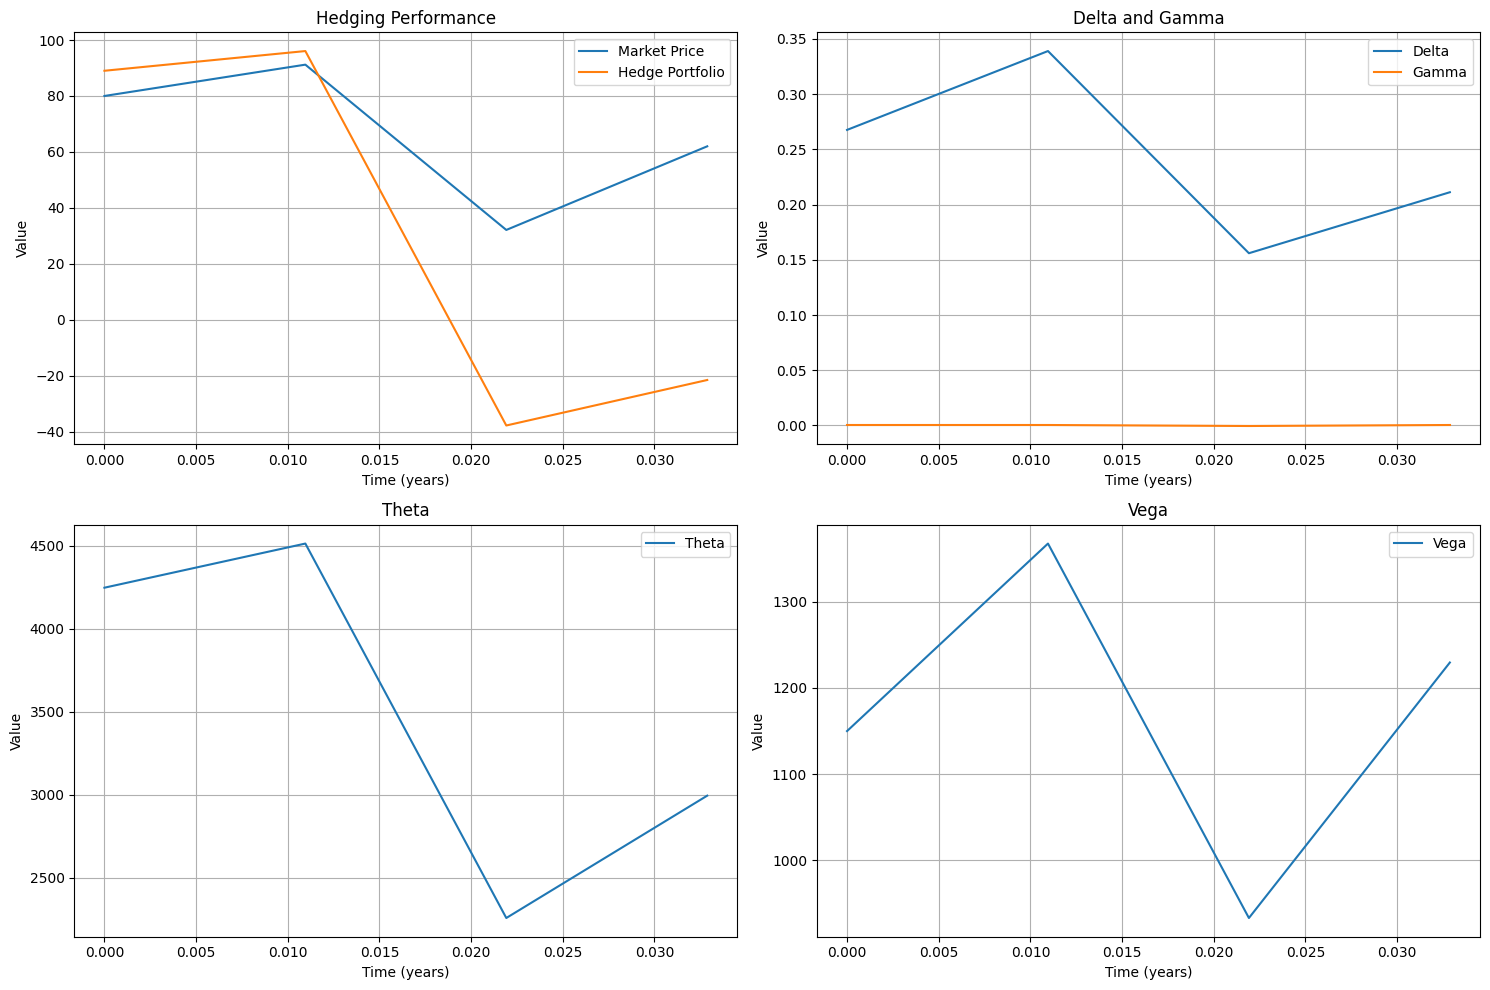


=== Hedging Analysis Summary ===
Number of time points: 4
Average Delta: 0.2435
Average Gamma: 0.0000
Average Theta: 3502.4080
Average Vega: 1170.0129
Average Hedging Error: -34.8988
Maximum Hedging Error: 83.5511

=== Portfolio Values ===
[ 89.01565809  96.06199507 -37.82179644 -21.55108772]

=== Market Prices ===
[80.  91.2 32.1 62. ]

=== Deltas ===
[0.2676463  0.33904197 0.1559895  0.211217  ]

=== Gammas ===
[ 2.27373675e-09  1.42108547e-10 -1.42108547e-10  2.84217094e-10]

=== Thetas ===
[4247.02989047 4513.20749385 2255.93691247 2993.45763363]


(array([ 89.01565809,  96.06199507, -37.82179644, -21.55108772]),
 array([80. , 91.2, 32.1, 62. ]),
 array([0.2676463 , 0.33904197, 0.1559895 , 0.211217  ]),
 array([ 2.27373675e-09,  1.42108547e-10, -1.42108547e-10,  2.84217094e-10]),
 array([4247.02989047, 4513.20749385, 2255.93691247, 2993.45763363]))

In [13]:
sample_data = pd.DataFrame({
        'Underlying Value': calls.loc[3:6]["Underlying Value"],  # sample underlying prices
     'Close': calls.loc[3:6]["LTP"],                 # sample market option prices
    'T': np.array([(datetime.strptime(calls.loc[i,"Expiry"], "%d-%b-%y") - datetime.strptime(calls.loc[i,"Date"], "%d-%b-%y")).days for i in range(3,7)])/365
})
hedging_analysis(sample_data, K, rf, 0.1386, N_steps=100, option_type='call')

#### Hedging Analysis for the Put Option

In [14]:
%%capture
option = puts.loc[6]
S0 = option["Underlying Value"]
K = option["Strike Price"]
T = (datetime.strptime(option["Expiry"], "%d-%b-%y") - datetime.strptime(option["Date"], "%d-%b-%y")).days/365
sigma = option["IV"]
rf = 0.0649  # risk-free rate (from 10 Year bond value)
N = 3

call_price, stock_tree, call_tree = binomial_tree(S0, K, T, rf, sigma, N, 
                                                 option_type='put', 
                                                 print_trees=True,
                                                 visualize=True)


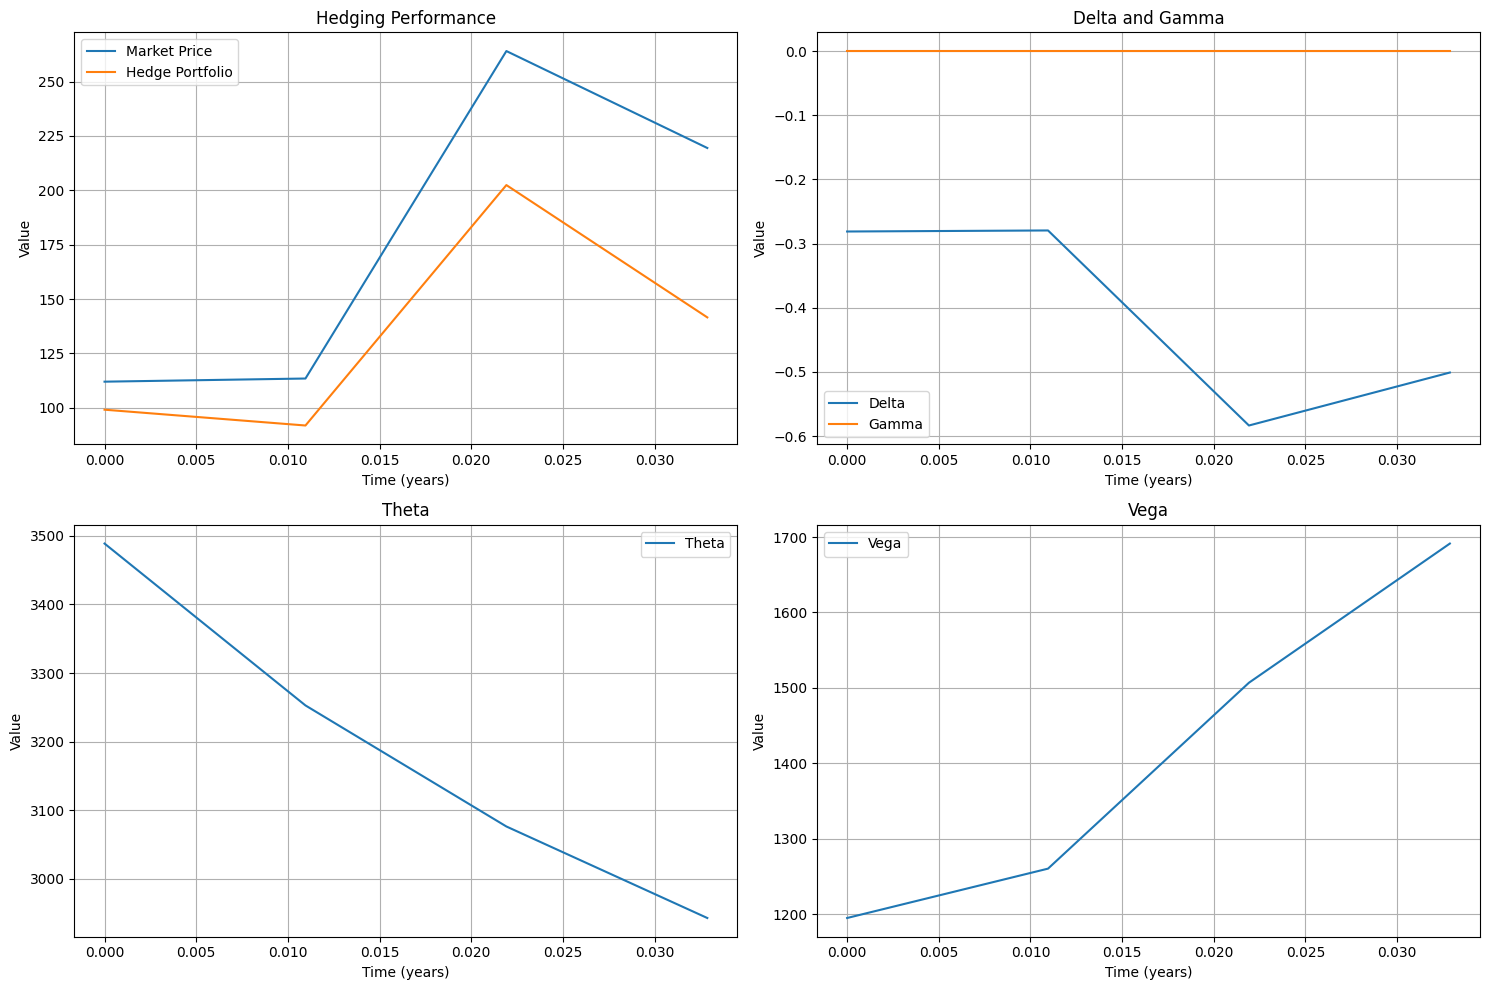


=== Hedging Analysis Summary ===
Number of time points: 4
Average Delta: -0.4112
Average Gamma: -0.0000
Average Theta: 3190.3363
Average Vega: 1413.4282
Average Hedging Error: -43.4788
Maximum Hedging Error: 77.8520

=== Portfolio Values ===
[ 99.17257133  91.90800295 202.40612664 141.59801733]

=== Market Prices ===
[112.05 113.5  264.   219.45]

=== Deltas ===
[-0.28114262 -0.27951275 -0.58339141 -0.50087914]

=== Gammas ===
[ 8.95283847e-09 -2.27373675e-09 -8.52651283e-09 -6.53699317e-09]

=== Thetas ===
[3488.76148942 3252.90627436 3076.51514882 2943.16211007]


(array([ 99.17257133,  91.90800295, 202.40612664, 141.59801733]),
 array([112.05, 113.5 , 264.  , 219.45]),
 array([-0.28114262, -0.27951275, -0.58339141, -0.50087914]),
 array([ 8.95283847e-09, -2.27373675e-09, -8.52651283e-09, -6.53699317e-09]),
 array([3488.76148942, 3252.90627436, 3076.51514882, 2943.16211007]))

In [15]:
sample_data = pd.DataFrame({
        'Underlying Value': puts.loc[3:6]["Underlying Value"],  # sample underlying prices
     'Close': puts.loc[3:6]["LTP"],                 # sample market option prices
    'T': np.array([(datetime.strptime(puts.loc[i,"Expiry"], "%d-%b-%y") - datetime.strptime(puts.loc[i,"Date"], "%d-%b-%y")).days for i in range(3,7)])/365
}    
)
hedging_analysis(sample_data, K, rf, 0.1386, N_steps=100, option_type='put')